In [1]:
#reset
import numpy as np
import pandas as pd
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import eofs
from eofs.xarray import Eof
import xarray as xr
import cartopy.crs as ccrs
#import xmovie

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size':10}

plt.rcParams.update(params)




In [7]:
url_sst='http://chapman.ceoas.oregonstate.edu/thredds/dodsC/CIOSS/HadISST/Monthly/HadISST_sst.nc'
ds       =xr.open_dataset(url_sst)
ds.time

<xarray.DataArray 'time' (time: 1765)>
array(['1870-01-16T11:59:59.505615234', '1870-02-14T23:59:59.340820312',
       '1870-03-16T11:59:59.340820312', ..., '2016-11-16T12:00:00.000000000',
       '2016-12-16T12:00:00.000000000', '2017-01-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2017-01-...
Attributes:
    long_name:      Time
    standard_name:  time

In [35]:
url_sst   ='https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
url_basins='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods'
ds       =xr.open_dataset(url_sst)
ds_basins=xr.open_dataset(url_basins);
ds.load();
ds_basins.load();

In [53]:
pacific=ds_basins.basin.isel(Z=0).squeeze();
pacific_mask=pacific.rename({'Y':'lat','X':'lon'}).interp_like(ds.sst);
pacific_mask=pacific_mask.where(pacific_mask==2).where(ds.lon>60)/2;

pacific_sst=ds.sst*pacific_mask
pacific_sst_anom=pacific_sst.groupby('time.month')-pacific_sst.groupby('time.month').mean('time')
pacific_sst_anom=pacific_sst_anom.sel(time=slice('2010','2020'))    
#pacific_sst_anom_eq=sst_anom.sel(lat=slice(50,-50))

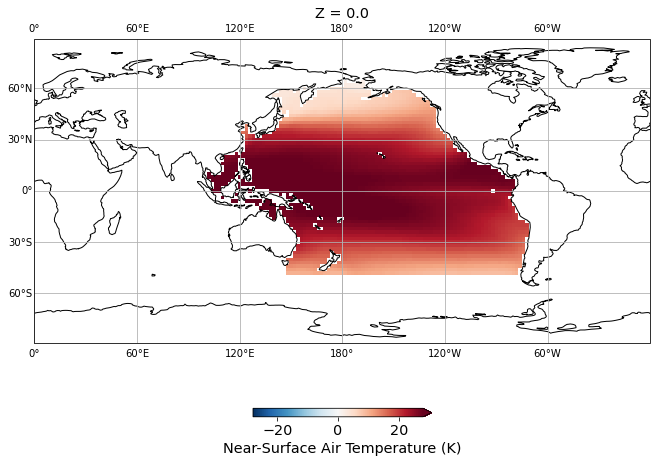

In [54]:
fig=plt.figure(figsize=(16,8))
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax.coastlines()
ax.gridlines(draw_labels=True)

pacific_sst.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.get_cmap('RdBu').reversed(),
              cbar_kwargs={'label':'Near-Surface Air Temperature (K)','shrink':0.2,'orientation':'horizontal'}
                             ,vmin=-28,vmax=28)

In [119]:
solver = Eof(pacific_sst_anom)
eofs = solver.eofs()
X0=-eofs.isel(mode=0)
X1=eofs.isel(mode=1)
#eofs.isel(mode=3).plot()

In [131]:
eigs=solver.eigenvalues()
V=np.cumsum(eigs)/np.sum(eigs)
V[[0,1,4]]

<xarray.DataArray 'eigenvalues' (mode: 3)>
array([0.33780512, 0.48013753, 0.66343864])
Coordinates:
  * mode     (mode) int64 0 1 4

In [60]:
ds_all=pacific_sst_anom=pacific_sst_anom.sel(time=slice('2010','2020'))
for neofs in [1,2,5,10]:
    for j in range(neofs):
        dot=eofs.isel(mode=j).drop('mode')*pacific_sst_anom
        if j==0:
            rec=eofs.isel(mode=j).drop('mode')*dot.sum(['lat','lon'])
        else:
            rec=rec+eofs.isel(mode=j).drop('mode')*dot.sum(['lat','lon'])
    rec=rec.rename('sst')
    ds_all=xr.concat([ds_all,rec],dim='eofs')    

In [61]:
ds_all

<xarray.DataArray (eofs: 5, time: 132, lat: 89, lon: 180)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2020-12-01
    Z        float32 0.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: eofs

In [109]:
ds_all.isel(time=slice(48,84)).time

<xarray.DataArray 'time' (time: 36)>
array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
       '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
       '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2016-12-01
    Z        float32 0.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80992.]
    _ChunkSizes:      1

In [115]:
#mov=Movie(ds_all.isel(eofs=0),cmap=cm.get_cmap('RdBu').reversed(),vmax=3,vmin=-3)
#mov.save('./mov/Pacific_sst_anomaly_All.mp4',framerate=12,overwrite_existing=True)
 
V=[0,1,2,5,10]    
for j in range(len(V)):
    mov=Movie(ds_all.isel(eofs=j).isel(time=slice(48,84)).drop('Z'),
          cmap=cm.get_cmap('RdBu').reversed(),
          vmax=2,
          vmin=-2,
          xlim=(100,300),
          ylim=(-55,65))
    mov.save('./mov/ENSO2016_anomaly_'+str(V[j])+'EOFS.mp4',framerate=4,overwrite_existing=True)

Movie created at ENSO2016_anomaly_0EOFS.mp4
Movie created at ENSO2016_anomaly_1EOFS.mp4
Movie created at ENSO2016_anomaly_2EOFS.mp4
Movie created at ENSO2016_anomaly_5EOFS.mp4
Movie created at ENSO2016_anomaly_10EOFS.mp4


In [63]:
mov=Movie(ds_all.isel(eofs=3),cmap=cm.get_cmap('RdBu').reversed(),vmax=3,vmin=-3)
mov.save('./mov/Pacific_sst_anomaly_5EOFs.mp4',gif_framerate=10,overwrite_existing=True)

Movie created at Pacific_sst_anomaly_5EOFs.mp4


In [64]:
mov=Movie(ds_all.isel(eofs=4),cmap=cm.get_cmap('RdBu').reversed(),vmax=3,vmin=-3)
mov.save('./mov/Pacific_sst_anomaly_10EOFs.mp4',gif_framerate=12,overwrite_existing=True)

Movie created at Pacific_sst_anomaly_10EOFs.mp4


In [1]:
#def plots(ds_all):
fig,axs=plt.subplots(2,2,figsize=(12,10),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0),})
tits=['all','1 EOF ','2 EOFs' , '5EOFS']
for j in range(2):
    for k in range(2):
        ax=axs[j,k]
        ax.coastlines()
        
        ax.gridlines(draw_labels=True)
        ds_all.isel(eofs=2*j+k).std('time').plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.get_cmap('RdBu').reversed(),
                      cbar_kwargs={'label':'','shrink':0.5,'orientation':'vertical'}
                                     ,vmin=-28,vmax=28)
        ax.set_title(tits[2*j+k])
        ax.set_extent([105,290,-50,60])

NameError: name 'plt' is not defined

In [87]:
def custom_plotfunc(ds, fig, tt, framedim="time"):
    fig,axs=plt.subplots(2,2,figsize=(12,10),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0),})
    tits=['all','1 EOF ','2 EOFs' , '5EOFS']
    for j in range(2):
        for k in range(2):
            ax=axs[j,k]
            ax.coastlines()

            ax.gridlines(draw_labels=True)
            ds_all.isel(eofs=2*j+k).std('time').plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.get_cmap('RdBu').reversed(),
                          cbar_kwargs={'label':'','shrink':0.5,'orientation':'vertical'}
                                         ,vmin=-28,vmax=28)
            ax.set_title(tits[2*j+k])
            ax.set_extent([110,290,-50,60])

/Users/cristi/miniconda3/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/cristi/miniconda3/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


TypeError: custom_plotfunc() got an unexpected keyword argument 'vmin'

<Figure size 1080x360 with 0 Axes>

In [16]:
ds_plot=ds.sel(time=slice('1920','2021'))    
ds_plot=ds_plot.assign(sst_anom=pacific_sst_anom)
ds_plot=ds_plot.assign(sst_anom_rec=rec)

In [116]:
eofs

<xarray.DataArray 'eofs' (mode: 132, lat: 89, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 ... 124 125 126 127 128 129 130 131
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    long_name:  empirical_orthogonal_functions

In [19]:
from xmovie import Movie
mov1=Movie(rec.isel(time=slice(0,60)),vmin=-3,vmax=3,cmap=cm.get_cmap('RdBu').reversed())
mov2=Movie(pacific_sst_anom.isel(time=slice(0,60)),vmin=-3,vmax=3,cmap=cm.get_cmap('RdBu').reversed())

In [21]:
mov1.save('./mov/mov1.mp4')
mov1.save('./mov/mov2.mp4')

Movie created at mov1.mp4
Movie created at mov2.mp4


In [ ]:
!pwd

In [ ]:
plt.subplot(2,1,1)
plt.plot(solver.eigenvalues()/np.sum(solver.eigenvalues()),'o')
plt.ylim(0,0.5)
plt.xlim(0,200)
plt.subplot(2,1,2)
plt.plot(np.cumsum(solver.eigenvalues())/np.sum(solver.eigenvalues()),'o')
plt.xlim(0,200)
plt.ylim(0,1)

### 

In [118]:
plt.figure(figsize=[30,20])
eigs=solver.VarianceFraction()
eigs=eigs/np.sum(eigs)
plt.plot(eigs[0:20],'o')
plt.grid()
print(eigs[0:3])

AttributeError: 'Eof' object has no attribute 'VarianceFraction'

<Figure size 2160x1440 with 0 Axes>

In [118]:

# load test dataset
ds = xr.tutorial.open_dataset('air_temperature').isel(time=slice(0,150))
# create movie object
mov = Movie(ds.air)

/Users/cristi/miniconda3/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/cristi/miniconda3/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


/Users/cristi/miniconda3/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/cristi/miniconda3/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

KeyboardInterrupt: 

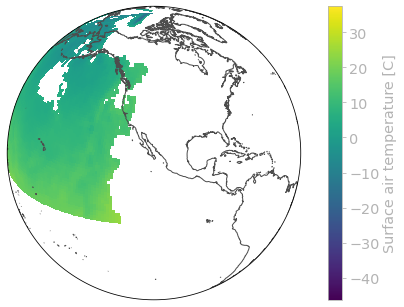

In [124]:
from xmovie.presets import rotating_globe
# specify custom plotfunctions (here a preset from xmovie)
mov = Movie(ds, plotfunc=rotating_globe)
mov.save('movie_rotating.gif', progress=True)

In [122]:
ds

<xarray.DataArray 'Tair' (time: 36, y: 205, x: 275)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 26.802619, 27.086035],
        [      nan,       nan, ..., 26.564739, 26.730649]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 24.29624 , 24.614224],
        [      nan,       nan, ..., 24.299677, 24.454399]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 27.311049, 27.673872],
        [      nan,       nan, ..., 27.008894, 27.23018 ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 28.422736, 28.687212],
        [      nan,       nan, ..., 28.185955, 28.20753 ]]])
Coordinates:
  * time     (time) float64 7.226e+05 7.226e+05 ... 7.236e+05 7.237e+05
    xc       (y, x) float64 ...
    yc       (y, x) float64 ...
Dimensions without coordinates: y, x
Attributes:
    units:           C
    long_name:       Surface air temperature
    type_preferred:  double
    time_rep:        instantaneous